In [11]:
# !pip install scipy osmnx contextily

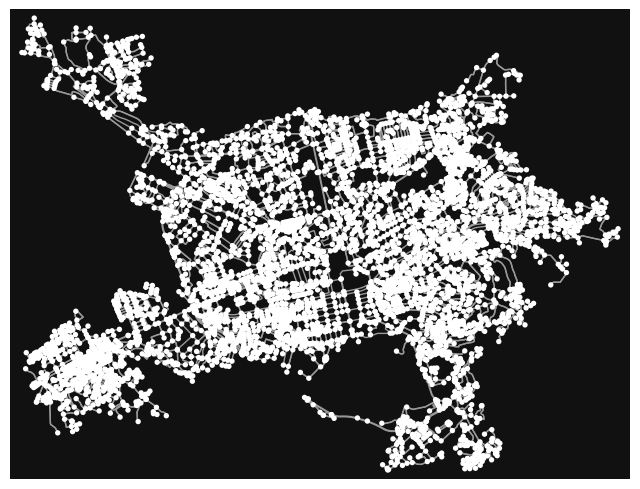

In [2]:
import osmnx
import shapely.geometry
import geopandas

import contextily
import matplotlib.pyplot

PLACE_NAME = "Tirana, Albania"
graph = osmnx.graph_from_place(
    PLACE_NAME,
    network_type="drive"
)
figure, ax = osmnx.plot_graph(graph)

In [3]:
edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)
display(edges.head())
print()
display(edges["highway"].value_counts())

osmid  oneway lanes                 name  \
u        v          key                                                 
15459891 15494062   0    458883732    True     2     Rruga Vaso Pasha   
         1840198326 0    674633067    True     1   Rruga Nikolla Tupe   
15460178 1843574977 0    255038660    True     1  Rruga Mustafa Qosja   
         4652332070 0    471055213    True   NaN  Rruga Mustafa Qosja   
15460384 15460178   0    255038660    True     1  Rruga Mustafa Qosja   

                               highway maxspeed reversed   length  \
u        v          key                                             
15459891 15494062   0      residential       30    False   76.275   
         1840198326 0      residential       20    False  179.497   
15460178 1843574977 0    living_street      NaN    False   37.479   
         4652332070 0    living_street      NaN    False   24.592   
15460384 15460178   0    living_street      NaN    False   41.506   

                                                                  geometry  \
u        v          key                                                      
15459891 15494062   0    LINESTRING (19.81635 41.31964, 19.81637 41.319...   
         1840198326 0    LINESTRING (19.81635 41.31964, 19.81642 41.319...   
15460178 1843574977 0    LINESTRING (19.80814 41.31982, 19.80832 41.319...   
         4652332070 0    LINESTRING (19.80814 41.31982, 19.80819 41.319...   
15460384 15460178   0    LINESTRING (19.80784 41.31953, 19.80814 41.31982)   

                         ref bridge junction access width tunnel  
u        v          key                                           
15459891 15494062   0    NaN    NaN      NaN    NaN   NaN    NaN  
         1840198326 0    NaN    NaN      NaN    NaN   NaN    NaN  
15460178 1843574977 0    NaN    NaN      NaN    NaN   NaN    NaN  
         4652332070 0    NaN    NaN      NaN    NaN   NaN    NaN  
15460384 15460178   0    NaN    NaN      NaN    NaN   NaN    NaN

highway
residential                     7318
living_street                   2031
tertiary                        1372
secondary                        980
primary                          545
trunk                             48
primary_link                      36
[living_street, residential]      29
trunk_link                        22
secondary_link                    19
unclassified                       4
tertiary_link                      1
Name: count, dtype: int64

In [17]:
def go_from_to(graph, location_from, location_to):
    # Transform the graph to UTM
    graph = osmnx.project_graph(graph) 

    # Extract reprojected nodes and edges
    nodes, edges = osmnx.graph_to_gdfs(graph)

    origin = (
        osmnx.geocode_to_gdf(location_from, which_result=1)  # fetch geolocation
        .to_crs(edges.crs)  # transform to UTM
        .at[0, "geometry"]  # pick geometry of first row
        .centroid  # use the centre point
    )

    destination = (
        osmnx.geocode_to_gdf(location_to)
        .to_crs(edges.crs)
        .at[0, "geometry"]
        .centroid
    )

    origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
    destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)

    # Find the shortest path between origin and destination
    route = osmnx.shortest_path(graph, origin_node_id, destination_node_id)
    route_nodes = nodes.loc[route]

    # Create a geometry for the shortest path
    route_line = shapely.geometry.LineString(
        list(route_nodes.geometry.values)
    )
    
    route_geom = geopandas.GeoDataFrame(
        {
            "geometry": [route_line],
            "osm_nodes": [route],
        },
        crs=edges.crs
    )

    # Calculate the route length
    route_geom["length_m"] = route_geom.length

    # display(route_geom.head())

    buildings = osmnx.features_from_place(
        PLACE_NAME,
        {
            "building" : True
        }
    ).to_crs(edges.crs)
    

    fig, ax = matplotlib.pyplot.subplots(figsize=(12,8))

    # Plot edges and nodes
    edges.plot(ax=ax, linewidth=0.75, color='gray')
    nodes.plot(ax=ax, markersize=2, color='gray')

    # Add buildings
    ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

    # Add the route
    ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

    # Add basemap
    contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

/home/pomodoren/Desktop/SUTi/ResMI/venv/lib/python3.12/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/home/pomodoren/Desktop/SUTi/ResMI/venv/lib/python3.12/site-packages/osmnx/features.py:294: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


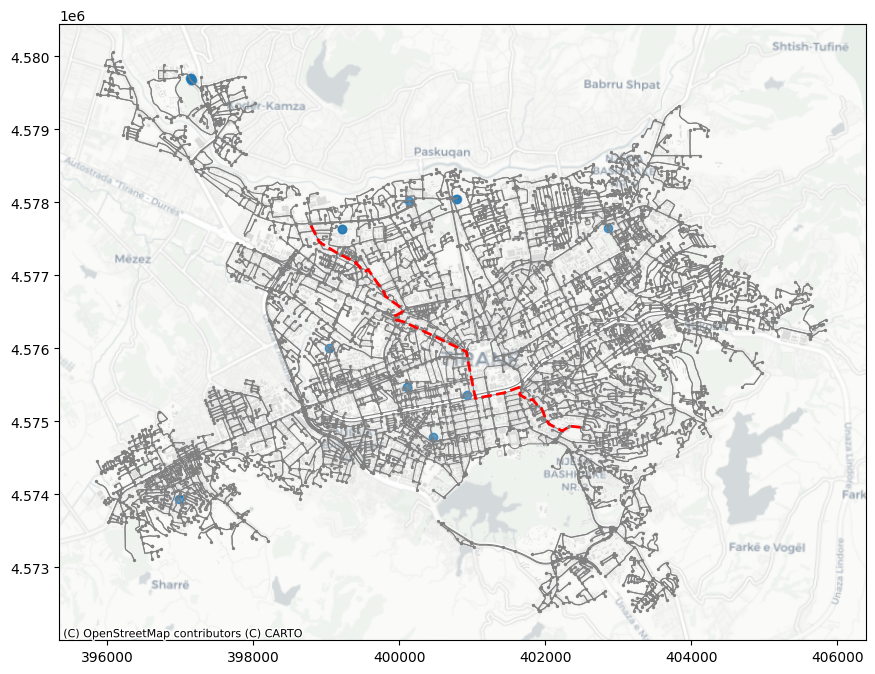

In [18]:
location_from = "Lapraka, Tirana"
location_to = "Qyteti Studenti, Tirana"
go_from_to(graph, location_from, location_to)